# Feature engineering

In [1]:
develop = False

# everything takes a few minutes, except IterativeImputer imputation, which takes 1.5-2 hours

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from random import choice, randint
from cmath import exp, pi

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from itertools import combinations

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

In [2]:
#split train and validate

train = pd.read_csv('data/cleaned_train.csv')#.sample(frac=0.01)
if develop:
    train, validation = train_test_split(train, test_size=0.2)
    validation = validation.reset_index(drop=True)
train = train.reset_index(drop=True)

test = pd.read_csv('data/cleaned_test.csv')#.sample(frac=0.01)

train.head(5)

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,0.0,0.0,Red,Trapezoid,Hamster,Russia,Bassoon,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990,3.0,2.0,4.0,3.0,21.0,57.0,6.0,3.0,0
1,1,1.0,1.0,0.0,0.0,1.0,Red,Star,Axolotl,NaN,Theremin,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af,3.0,5.0,3.0,5.0,24.0,151.0,7.0,7.0,0
2,2,0.0,1.0,0.0,0.0,0.0,Red,NaN,Hamster,Canada,Bassoon,b574c9841,708248125,5ddc9a726,745b909d1,NaN,3.0,NaN,1.0,14.0,16.0,106.0,5.0,9.0,0
3,3,NaN,0.0,0.0,0.0,0.0,Red,Circle,Hamster,Finland,Theremin,673bdf1f6,23edb8da3,3a33ef960,bdaa56dd1,f9d456e57,1.0,1.0,6.0,1.0,3.0,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,1.0,0.0,Red,Triangle,Hamster,Costa Rica,NaN,777d1ac2c,3a7975e46,bc9cc2a94,NaN,c5361037c,3.0,5.0,2.0,8.0,3.0,51.0,5.0,12.0,0


In [3]:
#number of missing values in row
train['na_count'] = train.isnull().sum(axis=1)
if develop:
    validation['na_count'] = validation.isnull().sum(axis=1)
test['na_count'] = test.isnull().sum(axis=1)

In [4]:
#missing value indicator columns for non-onehot columns

def add_na_indicator_columns(df):
    for col in ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 
                'nom_9', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month']:
        df[col+'_was_na'] = df[col].isnull().map({False: 0, True: 1})
    return df

train = add_na_indicator_columns(train)
if develop:
    validation = add_na_indicator_columns(validation)
test = add_na_indicator_columns(test)

In [5]:
#nom 0-4 onehot

cols = ['nom_{}'.format(i) for i in range(0,5)]
def fill_na(df):
    for col in cols:
        df[col] = df[col].fillna('was_na')
    return df

train = fill_na(train)
if develop:
    validation = fill_na(validation)
test = fill_na(test)

oh = OneHotEncoder(handle_unknown='ignore', sparse=False)
oh.fit(train[cols])
encoded_cols = oh.get_feature_names(cols)

def add_encoding_columns(df):
    encodings = pd.DataFrame(oh.transform(df[cols]), columns=encoded_cols)
    for col in encoded_cols:
        df[col] = encodings[col]
    return df

train = add_encoding_columns(train)
if develop:
    validation = add_encoding_columns(validation)
test = add_encoding_columns(test)

In [6]:
#nom 5-9 category member count

for col in ['nom_{}'.format(i) for i in range(5,10)]:
    counts = train[col].value_counts().reset_index()
    counts.columns = [col, col+'_count']
    
    train = pd.merge(train, counts, how='left')
    if develop:
        validation = pd.merge(validation, counts, how='left')
    test = pd.merge(test, counts, how='left')

In [7]:
#mean target encodings for high cardinality features (nom 5-9)
#smoothed because there are many categories with only a few data points
m = 300
#m data points needed for category mean to have more weight than total mean

for col in ['nom_{}'.format(i) for i in range(5,10)]:
    
    total_mean = train['target'].mean()
    counts = train.groupby(col)['target'].count()
    means = train.groupby(col)['target'].mean()
    smoothed_mean = (counts * means + m * total_mean) / (counts + m)
    
    train[col+'_target_mean'] = train[col].map(smoothed_mean)
    if develop:
        validation[col+'_target_mean'] = validation[col].map(smoothed_mean)
    test[col+'_target_mean'] = test[col].map(smoothed_mean)

In [8]:
#nom 5-9 delete after target encodings
train = train.drop(['nom_{}'.format(i) for i in range(5,10)], axis=1)
if develop:
    validation = validation.drop(['nom_{}'.format(i) for i in range(5,10)], axis=1)
test = test.drop(['nom_{}'.format(i) for i in range(5,10)], axis=1)

In [9]:
%%time
impute = True

need_imputation = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 
                   'nom_5_count', 'nom_5_target_mean', 'nom_6_count', 'nom_6_target_mean', 'nom_7_count', 
                   'nom_7_target_mean', 'nom_8_count', 'nom_8_target_mean', 'nom_9_count', 'nom_9_target_mean', 
                   'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month']

# these columns' imputed values are to be coerced into the 
# original value set because we want to do a groupby on them
int_values = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 
              'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 
              'day', 'month']

to_remove = ['id', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']# + ['target']

if impute:
    imp = IterativeImputer(sample_posterior=True, max_iter=8)
    imp.fit(train.drop(to_remove + ['target'], axis=1))
    
    def transform(df):
        to_remove_this = list(to_remove)
        if 'target' in df.columns:
            to_remove_this += ['target']
        
        df_subset = df.drop(to_remove_this, axis=1)
        df_subset = pd.DataFrame(imp.transform(df_subset), columns=df_subset.columns)
        
        for col in int_values:
            #df_subset[col].hist(bins=30)
            #plt.yscale('log')
            #plt.show()
            
            #imputation is not int-accurate
            df_subset[col] = np.clip(df_subset[col], df[col].min(), df[col].max()).apply(round)
            
            #df_subset[col].hist(bins=30)
            #plt.yscale('log')
            #plt.show()
        
        df = pd.concat([df_subset, df[to_remove_this]], axis=1)
        return df
    
    train = transform(train)
    if develop:
        validation = transform(validation)
    test = transform(test)
    
else:
    #na replacement by picking from the same distribution
    #could try IterativeImputer instead

    for col in need_imputation:
        colvals = train[col].dropna().values

        def get_from_distribution_if_na(x):
            if np.isnan(x):
                return choice(colvals)
            else:
                return x

        train[col] = train[col].map(get_from_distribution_if_na)
        if develop:
            validation[col] = validation[col].map(get_from_distribution_if_na)
        test[col] = test[col].map(get_from_distribution_if_na)

Wall time: 4h 5min 27s


In [10]:
%%time
#mean target encodings, "crossvalidated" (5)
N = 5
means_for = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']

train['grouping'] = [randint(1,N) for i in range(len(train))]
if develop:
    validation['grouping'] = [randint(1,N) for i in range(len(validation))]
test['grouping'] = [randint(1,N) for i in range(len(test))]

for col in means_for:
    train_subsets = []
    if develop:
        validation_subsets = []
    test_subsets = []
    
    for i in range(1,N+1):
        train_subset = train[train['grouping'] == i]
        if develop:
            validation_subset = validation[validation['grouping'] == i]
        test_subset = test[test['grouping'] == i]
        
        means = train_subset.groupby(col)['target'].mean()
        
        train_subset[col+'_target_mean'] = train_subset[col].map(means)
        if develop:
            validation_subset[col+'_target_mean'] = validation_subset[col].map(means)
        test_subset[col+'_target_mean'] = test_subset[col].map(means)
        train_subsets.append(train_subset)
        if develop:
            validation_subsets.append(validation_subset)
        test_subsets.append(test_subset)
    
    train = pd.concat(train_subsets, ignore_index=True)
    if develop:
        validation = pd.concat(validation_subsets, ignore_index=True)
    test = pd.concat(test_subsets, ignore_index=True)

train = train.drop('grouping', axis=1)
if develop:
    validation = validation.drop('grouping', axis=1)
test = test.drop('grouping', axis=1)

Wall time: 1min 38s


In [11]:
#nom 3 latlong
latmap = {
    'Canada': 61,
    'Costa Rica': 10,
    'Finland': 63,
    'Russia': 60,
    'India': 21,
    'China': 33,
    'was_na': -100 
}
longmap = {
    'Canada': -110,
    'Costa Rica': -84,
    'Finland': 25,
    'Russia': 65,
    'India': 80,
    'China': 105,
    'was_na': -120
}

train['nom_3_lat'] = train['nom_3'].map(latmap)
train['nom_3_long'] = train['nom_3'].map(longmap)
if develop:
    validation['nom_3_lat'] = validation['nom_3'].map(latmap)
    validation['nom_3_long'] = validation['nom_3'].map(longmap)
test['nom_3_lat'] = test['nom_3'].map(latmap)
test['nom_3_long'] = test['nom_3'].map(longmap)

In [12]:
#nom 2,4 type groupings
train['nom_2_not_mammal'] = (train['nom_2'] == 'Axolotl') | (train['nom_2'] == 'Snake')
if develop:
    validation['nom_2_not_mammal'] = (validation['nom_2'] == 'Axolotl') | (validation['nom_2'] == 'Snake')
test['nom_2_not_mammal'] = (test['nom_2'] == 'Axolotl') | (test['nom_2'] == 'Snake')

train['nom_4_wind'] = (train['nom_4'] == 'Bassoon') | (train['nom_4'] == 'Oboe')
if develop:
    validation['nom_4_wind'] = (validation['nom_4'] == 'Bassoon') | (validation['nom_4'] == 'Oboe')
test['nom_4_wind'] = (test['nom_4'] == 'Bassoon') | (test['nom_4'] == 'Oboe')

In [13]:
%%time
#day and month cyclical encodings using complex roots of 1 as cartesian coordinates
def nth_roots_of_unity(n):
    return [exp(2*k*pi*1j/n) for k in range(n)]
def getx(value, n):
    value = np.clip(value, 1, n) #imputation might cause out-of-range values
    return nth_roots_of_unity(n)[int(value)-1].real
def gety(value, n):
    value = np.clip(value, 1, n)
    return nth_roots_of_unity(n)[int(value)-1].imag

train['day_x'] = train['day'].apply(getx, n=7)
train['day_y'] = train['day'].apply(gety, n=7)
if develop:
    validation['day_x'] = validation['day'].apply(getx, n=7)
    validation['day_y'] = validation['day'].apply(gety, n=7)
test['day_x'] = test['day'].apply(getx, n=7)
test['day_y'] = test['day'].apply(gety, n=7)

train['month_x'] = train['month'].apply(getx, n=12)
train['month_y'] = train['month'].apply(gety, n=12)
if develop:
    validation['month_x'] = validation['month'].apply(getx, n=12)
    validation['month_y'] = validation['month'].apply(gety, n=12)
test['month_x'] = test['month'].apply(getx, n=12)
test['month_y'] = test['month'].apply(gety, n=12)

Wall time: 3min 29s


In [14]:
#drop nominals (and day and month?)
train = train.drop(['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'], axis=1)
if develop:
    validation = validation.drop(['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'], axis=1)
test = test.drop(['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'], axis=1)

In [15]:
#smaller datatypes
#some normally int values are float because imputation does not produce perfectly rounded numbers and 
#trees can find a best split position without me splitting them myself and potentially ruining some information
types = {
    'id': 'int32', 
    'bin_0': 'int8', 'bin_1': 'int8', 'bin_2': 'int8', 'bin_3': 'int8', 'bin_4': 'int8', 
    'ord_0': 'int8', 'ord_1': 'int8', 'ord_2': 'int8', 'ord_3': 'int8', 'ord_4': 'int8', 'ord_5': 'int16', 
    'day': 'int8', 'month': 'int8', 
    'nom_2_not_mammal': 'float16', 'nom_3_lat': 'float16', 'nom_3_long': 'float16', 'nom_4_wind': 'float16', 
    'day_x': 'float16', 'day_y': 'float16', 'month_x': 'float16', 'month_y': 'float16', 
    'nom_5_count': 'float16', 'nom_6_count': 'float16', 'nom_7_count': 'float16', 'nom_8_count': 'float16', 
    'nom_9_count': 'float16', 
    'bin_0_target_mean': 'float16', 'bin_1_target_mean': 'float16', 'bin_2_target_mean': 'float16', 
    'bin_3_target_mean': 'float16', 'bin_4_target_mean': 'float16', 'ord_0_target_mean': 'float16', 
    'ord_1_target_mean': 'float16', 'ord_2_target_mean': 'float16', 'ord_3_target_mean': 'float16', 
    'ord_4_target_mean': 'float16', 'ord_5_target_mean': 'float16', 
    'day_target_mean': 'float16', 'month_target_mean': 'float16', 
    'nom_0_target_mean': 'float16', 'nom_1_target_mean': 'float16', 'nom_2_target_mean': 'float16', 
    'nom_3_target_mean': 'float16', 'nom_4_target_mean': 'float16', 'nom_5_target_mean': 'float16', 
    'nom_6_target_mean': 'float16', 'nom_7_target_mean': 'float16', 'nom_8_target_mean': 'float16', 
    'nom_9_target_mean': 'float16', 
    'na_count': 'float16', 
    'bin_0_was_na': 'float16', 'bin_1_was_na': 'float16', 'bin_2_was_na': 'float16', 'bin_3_was_na': 'float16', 
    'bin_4_was_na': 'float16', 'nom_5_was_na': 'float16', 'nom_6_was_na': 'float16', 'nom_7_was_na': 'float16', 
    'nom_8_was_na': 'float16', 'nom_9_was_na': 'float16', 'ord_0_was_na': 'float16', 'ord_1_was_na': 'float16', 
    'ord_2_was_na': 'float16', 'ord_3_was_na': 'float16', 'ord_4_was_na': 'float16', 'ord_5_was_na': 'float16', 
    'day_was_na': 'float16', 'month_was_na': 'float16', 
    'nom_0_Blue': 'float16', 'nom_0_Green': 'float16', 'nom_0_Red': 'float16', 'nom_0_was_na': 'float16', 
    'nom_1_Circle': 'float16', 'nom_1_Polygon': 'float16', 'nom_1_Square': 'float16', 'nom_1_Star': 'float16', 
    'nom_1_Trapezoid': 'float16', 'nom_1_Triangle': 'float16', 'nom_1_was_na': 'float16', 'nom_2_Axolotl': 'float16', 
    'nom_2_Cat': 'float16', 'nom_2_Dog': 'float16', 'nom_2_Hamster': 'float16', 'nom_2_Lion': 'float16', 
    'nom_2_Snake': 'float16', 'nom_2_was_na': 'float16', 'nom_3_Canada': 'float16', 'nom_3_China': 'float16', 
    'nom_3_Costa Rica': 'float16', 'nom_3_Finland': 'float16', 'nom_3_India': 'float16', 'nom_3_Russia': 'float16', 
    'nom_3_was_na': 'float16', 'nom_4_Bassoon': 'float16', 'nom_4_Oboe': 'float16', 'nom_4_Piano': 'float16', 
    'nom_4_Theremin': 'float16', 'nom_4_was_na': 'float16'
}

targettype = {'target': 'int8'}

train = train.astype(types)
train = train.astype(targettype)
if develop:
    validation = validation.astype(types)
    validation = validation.astype(targettype)
test = test.astype(types)

[0.48459325 0.47894408]
[0.48459325 0.96353733]


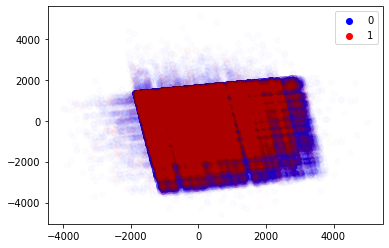

Wall time: 24.4 s


In [16]:
%%time
# looking at PCA before adding >1000 pairwise interactions

pca = PCA(n_components=2)
pca.fit(train.drop(['id', 'target'], axis=1))
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

def transform(df):
    to_drop = ['id']
    if 'target' in df.columns:
        to_drop += ['target']
    
    components = pd.DataFrame(
        pca.transform(df.drop(to_drop, axis=1)), 
        columns=['PCA_1', 'PCA_2'], dtype='float32')
    return pd.concat([df, components], axis=1)

train_ = transform(train)

a = plt.scatter(train_[train_['target']==0]['PCA_1'], 
                train_[train_['target']==0]['PCA_2'], 
                alpha = 0.01, color='b')
b = plt.scatter(train_[train_['target']==1]['PCA_1'], 
                train_[train_['target']==1]['PCA_2'], 
                alpha = 0.01, color='r')
leg = plt.legend([a,b],['0','1'])
for lh in leg.legendHandles: # make markers in legend opaque
    lh.set_alpha(1)
plt.show()

This is probably the most uniformly rectangular PCA graph I've ever seen. Taking into account this and the fact that the first 2 principal components explain practically all of the variance while their plot shows perfect target class overlap, there is no doubt that this dataset has been synthetically made with many feature interactions so it would be difficult to predict the target value

In [17]:
%%time

# pairwise multiplication interactions
# cols to look at
need_interactions = [
    'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
    
    'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5',
    'day', 'month',
    'nom_2_not_mammal', 'nom_3_lat', 'nom_3_long', 'nom_4_wind',
    'day_x', 'day_y', 'month_x', 'month_y',
    
    'nom_0_Blue', 'nom_0_Green', 'nom_0_Red', 'nom_1_Circle', 'nom_1_Polygon', 'nom_1_Square', 'nom_1_Star', 
    'nom_1_Trapezoid', 'nom_1_Triangle', 'nom_2_Axolotl', 'nom_2_Cat', 'nom_2_Dog', 'nom_2_Hamster', 
    'nom_2_Lion', 'nom_2_Snake', 'nom_3_Canada', 'nom_3_China', 'nom_3_Costa Rica', 'nom_3_Finland', 
    'nom_3_India', 'nom_3_Russia', 'nom_4_Bassoon', 'nom_4_Oboe', 'nom_4_Piano', 'nom_4_Theremin'
]

interaction_cols = []

for a, b in combinations(need_interactions, 2):
    new = a + '_x_' + b
    train[new] = train[a] * train[b]
    if develop:
        validation[new] = validation[a] * validation[b]
    test[new] = test[a] * test[b]
    interaction_cols.append(new)

Wall time: 49.3 s


[0.72836577 0.15357685]
[0.72836577 0.88194262]


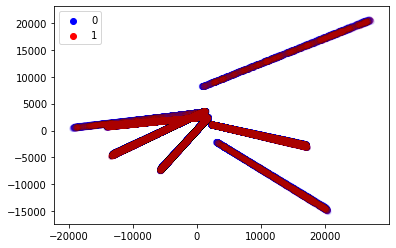

Wall time: 2min 10s


In [18]:
%%time
#PCA components

pca = PCA(n_components=2)
pca.fit(train.drop(['id', 'target'], axis=1))
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

def transform(df):
    to_drop = ['id']
    if 'target' in df.columns:
        to_drop += ['target']
    
    components = pd.DataFrame(
        pca.transform(df.drop(to_drop, axis=1)), 
        columns=['PCA_1', 'PCA_2'], dtype='float32')
    return pd.concat([df, components], axis=1)

train = transform(train)
if develop:
    validation = transform(validation)
test = transform(test)

a = plt.scatter(train[train['target']==0]['PCA_1'], 
                train[train['target']==0]['PCA_2'], 
                alpha = 0.01, color='b')
b = plt.scatter(train[train['target']==1]['PCA_1'], 
                train[train['target']==1]['PCA_2'], 
                alpha = 0.01, color='r')
leg = plt.legend([a,b],['0','1'])
for lh in leg.legendHandles: # make markers in legend opaque
    lh.set_alpha(1)
plt.show()

Again, this dataset surprises with a fascinating PCA. This one, however, might encode more meaning than the previous one, as there are 6/7 lines visible. 

In [19]:
#check for no nas
print(train.isna().sum().sum())
if develop:
    print(validation.isna().sum().sum())
print(test.isna().sum().sum())

0
0


In [20]:
#reorder columns for viewing comfort
col_order = [
    'id',
    'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
    'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5',
    'day', 'month',
    'nom_2_not_mammal', 'nom_3_lat', 'nom_3_long', 'nom_4_wind',
    'day_x', 'day_y', 'month_x', 'month_y',
    'nom_5_count', 'nom_6_count', 'nom_7_count', 'nom_8_count', 'nom_9_count',
    'PCA_1', 'PCA_2', 
    'bin_0_target_mean', 'bin_1_target_mean', 'bin_2_target_mean', 'bin_3_target_mean', 'bin_4_target_mean',
    'ord_0_target_mean', 'ord_1_target_mean', 'ord_2_target_mean', 'ord_3_target_mean', 'ord_4_target_mean', 
    'ord_5_target_mean', 'day_target_mean', 'month_target_mean',
    'nom_0_target_mean', 'nom_1_target_mean', 'nom_2_target_mean', 'nom_3_target_mean', 'nom_4_target_mean',
    'nom_5_target_mean', 'nom_6_target_mean', 'nom_7_target_mean', 'nom_8_target_mean', 'nom_9_target_mean',
    'na_count',
    'bin_0_was_na', 'bin_1_was_na', 'bin_2_was_na', 'bin_3_was_na', 'bin_4_was_na',
    'nom_5_was_na', 'nom_6_was_na', 'nom_7_was_na', 'nom_8_was_na', 'nom_9_was_na',
    'ord_0_was_na', 'ord_1_was_na', 'ord_2_was_na', 'ord_3_was_na', 'ord_4_was_na', 'ord_5_was_na',
    'day_was_na', 'month_was_na',
    'nom_0_Blue', 'nom_0_Green', 'nom_0_Red', 'nom_0_was_na', 'nom_1_Circle', 'nom_1_Polygon', 'nom_1_Square', 
    'nom_1_Star', 'nom_1_Trapezoid', 'nom_1_Triangle', 'nom_1_was_na', 'nom_2_Axolotl', 'nom_2_Cat', 'nom_2_Dog', 
    'nom_2_Hamster', 'nom_2_Lion', 'nom_2_Snake', 'nom_2_was_na', 'nom_3_Canada', 'nom_3_China', 'nom_3_Costa Rica', 
    'nom_3_Finland', 'nom_3_India', 'nom_3_Russia', 'nom_3_was_na', 'nom_4_Bassoon', 'nom_4_Oboe', 'nom_4_Piano', 
    'nom_4_Theremin', 'nom_4_was_na'#,
    #'target' not in test
] + interaction_cols
print(len(train.columns), len(col_order)+1)
train = train[col_order + ['target']]
if develop:
    validation = validation[col_order + ['target']]
test = test[col_order]

1137 1137


In [21]:
#pickle
if develop:
    train.to_pickle('data/train.p')
    validation.to_pickle('data/validation.p')
else:
    train.to_pickle('data/all.p')
test.to_pickle('data/test.p')